<a href="https://colab.research.google.com/github/GornostaevGO/StatPrak24/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iris classification

One Chinese proverb says: "A journey of a thousand miles begins with a single step", and as far as I know the first step in data collection belongs to Fisher, 1936, and his famous 'Iris' dataset (https://archive.ics.uci.edu/dataset/53/iris). This data is widely used in different courses and educational literature as a great example of classification problem. Let's take a closer look.

Data description given on the site:

Attribute Information:
   1. sepal length in cm
   2. sepal width in cm
   3. petal length in cm
   4. petal width in cm
   5. class:
      -- Iris Setosa
      -- Iris Versicolour
      -- Iris Virginica

In [1]:
# importing useful libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.special import expit
from sklearn.model_selection import KFold
import scipy.stats as stats
from scipy.stats import zscore

In [2]:
df = pd.read_csv('/content/iris.data', header=None, names=['sepal_length','sepal_width','petal_length','petal_width','class_'])
print('Data size l = {} rows.'.format(len(df)))
print('Our classes are:\n{}'.format('\n'.join(df.class_.unique())))
df.sample(5)

Data size l = 150 rows.
Our classes are:
Iris-setosa
Iris-versicolor
Iris-virginica


,sepal_length,sepal_width,petal_length,petal_width,class_
147,6.5,3.0,5.2,2.0,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
107,7.3,2.9,6.3,1.8,Iris-virginica
59,5.2,2.7,3.9,1.4,Iris-versicolor
19,5.1,3.8,1.5,0.3,Iris-setosa


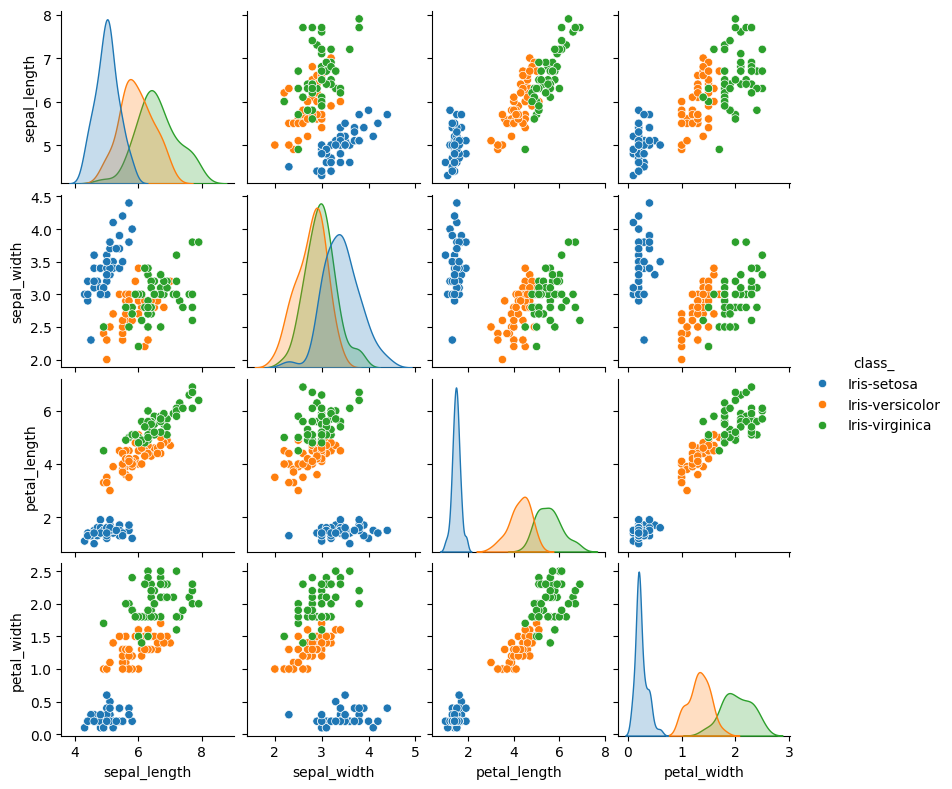

In [3]:
# let's explore 2-joint probability distribution of given attributes
sns.pairplot(df, hue='class_', height=2)
plt.show()

It's pretty obvious that we can separate 'setosa' class from two others by one of petal features just by a single line, let's do it.

In [4]:
setosa_max_petal = df.loc[df['class_'] == 'Iris-setosa', 'petal_length'].max()
not_setosa_min_petal = df.loc[df['class_'] != 'Iris-setosa', 'petal_length'].min()
print('Setosa max petal length: {} cm, other 2 classes min petal length: {} cm.'.format(setosa_max_petal, not_setosa_min_petal))

Setosa max petal length: 1.9 cm, other 2 classes min petal length: 3.0 cm.


In [5]:
# now we will examine only classes Versicolor and Virginica
binary_df = df.drop(index=df.index[df['class_'] == 'Iris-setosa'])
binary_df.loc[df['class_'] == 'Iris-versicolor', df.columns == 'class_'] = 0
binary_df.loc[df['class_'] == 'Iris-virginica', df.columns == 'class_'] = 1
binary_df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,class_
101,5.8,2.7,5.1,1.9,1
142,5.8,2.7,5.1,1.9,1
66,5.6,3.0,4.5,1.5,0
148,6.2,3.4,5.4,2.3,1
70,5.9,3.2,4.8,1.8,0


In the seminars we learnt about logistic regression model, let's try to implement it manually. <br>
Loss function for binary classification (logistic regression):
$$  L(y, \hat{y}) = - \left[ y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right]  $$
I want to implement SGD (saw this method while learning python and ml basics).


In [6]:
class SGD_LogRegressor():
    def __init__(
        self,
        lr=0.1, # learning rate
        max_steps=1e4,
        batch_size=8,
        threshold=0.5
    ):
        self.lr = lr
        self.max_steps = max_steps
        self.batch_size = batch_size
        self.threshold = threshold
        self.erros = None
        self.W = None # weights

    def _sigmoid(self, x):
        return expit(x)

    # Model fitting
    def fit(self, X, Y):
        self.errors = np.zeros(int(self.max_steps))

        ones_column = np.ones((X.shape[0], 1))
        X_copy = np.concatenate((X, ones_column), axis=1) # added a column of ones (intercept)
        self.W = np.random.normal(0, 1, X_copy.shape[1])
        self.W[-1] = np.mean(Y)

        step = 0
        while step < self.max_steps:
            batch = np.random.choice(X_copy.shape[0], size=self.batch_size, replace=False) # stochastics
            X_grad = X_copy[batch, :]
            Y_grad = Y[batch]
            prediction = self._sigmoid(X_grad @ self.W)

            grad_loss = np.dot(X_grad.T, prediction - Y_grad)
            batch_grad = (1 / self.batch_size) * grad_loss

            new_weights = self.W - self.lr * batch_grad

            self.W = new_weights
            loss = self.binary_cross_entropy(Y_grad, prediction) # convergence exploring
            self.errors[step] = loss
            step += 1

        return self

    # Model prediction
    def predict(self, X):
        y_pr_pred = self.predict_proba(X)
        pred = np.where(y_pr_pred >= self.threshold, 1, 0)
        return pred

    # Model probability prediction
    def predict_proba(self, X):
        sigmoid = self._sigmoid
        ones_column = np.ones((X.shape[0], 1))
        X_copy = np.concatenate((X, ones_column), axis=1)
        pr_prediction = sigmoid(X_copy @ self.W)
        return pr_prediction

    # Our loss-function
    def binary_cross_entropy(self, y_true, y_pred):
        eps = 1e-15  # small value to prevent log(0)
        n = len(y_true)
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return np.sum(-(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)))/n



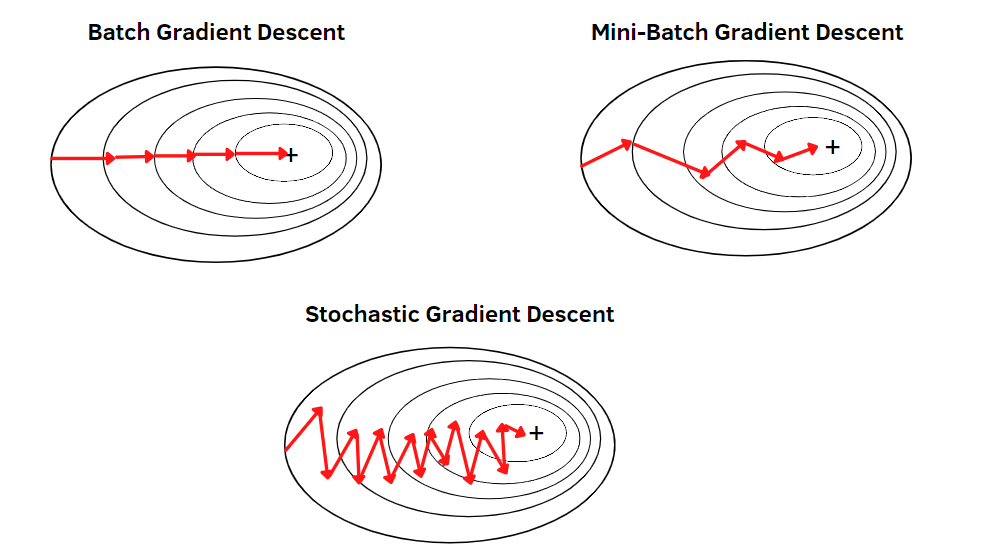

In [7]:
Y = np.array(binary_df.class_, dtype=np.float64)
X = np.array(binary_df.drop('class_', axis=1), dtype=np.float64)

In the cell below you can tune hyperparametrs of this model and observe it's convergence rate.

Accuracy = 1.0


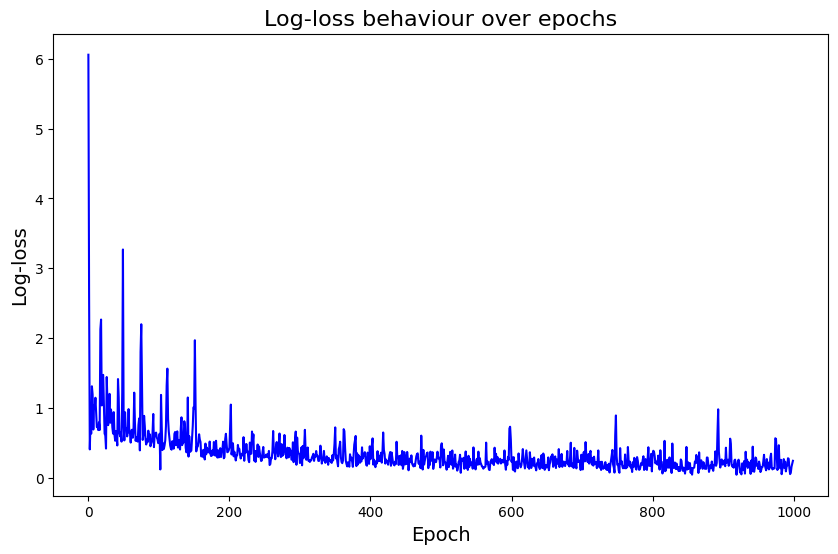

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
model = SGD_LogRegressor(max_steps=1e3, lr=0.1, batch_size=8)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy = {}'.format(accuracy))

plt.figure(figsize=(10, 6))
plt.plot(range(int(model.max_steps)), model.errors, color='blue')
plt.title('Log-loss behaviour over epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Log-loss', fontsize=14)
plt.show()

Now I want to cross-validate my model and to compare it with LogisticRegression from sklearn!

In [9]:
def cross_validation(model1, model2, X, Y, k=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies1 = []
    accuracies2 = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        model1.fit(X_train, Y_train)
        Y_pred1 = model1.predict(X_test)

        model2.fit(X_train, Y_train)
        Y_pred2 = model2.predict(X_test)

        accuracy1 = accuracy_score(Y_test, Y_pred1)
        accuracy2 = accuracy_score(Y_test, Y_pred2)
        accuracies1.append(accuracy1)
        accuracies2.append(accuracy2)

    return np.mean(accuracies1), np.std(accuracies1), np.mean(accuracies2), np.std(accuracies2)

In [10]:
# fitting model, these are my hyperparameters
model = SGD_LogRegressor()

# now we will cross-validate our model and compare it with
res = cross_validation(model, LogisticRegression(), X, Y)
print('Implemented model: Mean = {:.2f}, std = {:.2f} \nSklearn model: Mean = {:.2f}, std = {:.2f}'.format(res[0], res[1], res[2], res[3]))

Implemented model: Mean = 0.96, std = 0.05 
Sklearn model: Mean = 0.97, std = 0.05


As we can see our model is a bit worse. <br>
The reason for it is that Sklearn log-regressor is using regularizations and due to our data being rather correlated thats a helpful method.

(You can see correlation matrix below)

In [11]:
corr = binary_df.drop('class_',axis=1).corr().round(3)
corr.style.background_gradient(cmap='coolwarm').format(precision = 3)
# petal_length and sepal_length are nearly linearly dependent!

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000,0.554,0.828,0.594
sepal_width,0.554,1.000,0.520,0.566
petal_length,0.828,0.520,1.000,0.823
petal_width,0.594,0.566,0.823,1.000


## To sum it up, how would I solve the classification problem on this dataset?

In [12]:
# me vs sklearn
X = df.drop('class_', axis=1)
y = df['class_']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1).sort_index()

print(len(df_train))
df_train.sample(5)

120


,sepal_length,sepal_width,petal_length,petal_width,class_
85,6.0,3.4,4.5,1.6,Iris-versicolor
111,6.4,2.7,5.3,1.9,Iris-virginica
50,7.0,3.2,4.7,1.4,Iris-versicolor
3,4.6,3.1,1.5,0.2,Iris-setosa
145,6.7,3.0,5.2,2.3,Iris-virginica


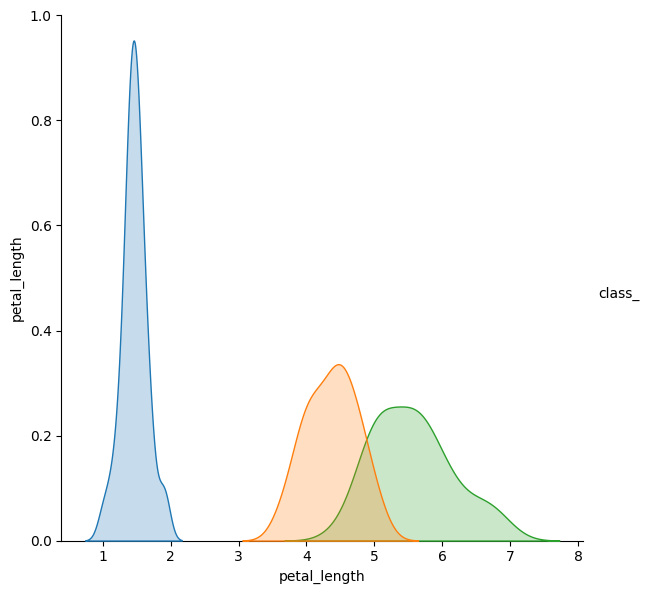

In [13]:
# as I already know from previous data analysis (to avoid repeating myself): petal_length is a good indicator for Iris-setosa
# let's look at its distribution for different classes on our train dataset
sns.pairplot(df_train[['petal_length','class_']], hue='class_', height=6)
plt.show()

40


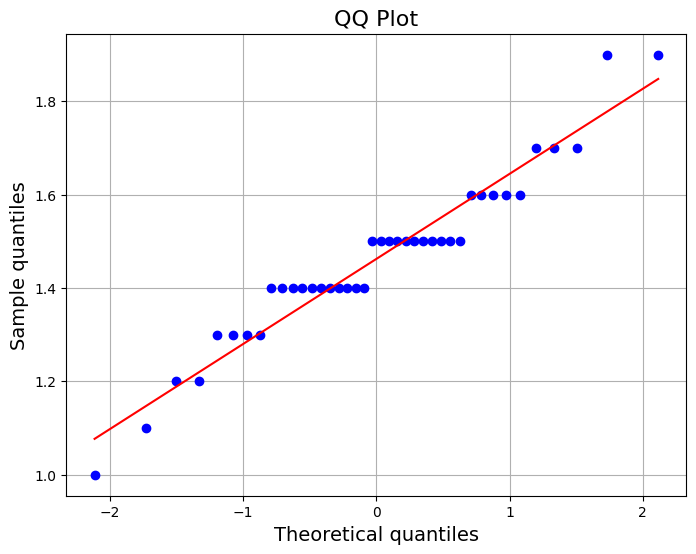

In [14]:
# petal length of setosa looks quite similar to normal, is that so?
data = np.array(df_train[df_train['class_'] == 'Iris-setosa'].petal_length)
print(len(data))
plt.figure(figsize=(8, 6))
stats.probplot(data, dist="norm", plot=plt)
plt.title('QQ Plot', fontsize=16)
plt.xlabel('Theoretical quantiles', fontsize=14)
plt.ylabel('Sample quantiles', fontsize=14)
plt.grid()
plt.show()

We have not much data (~ less than 50 rows in df_train for setosa), but still QQ-plot looks not so bad. Moreover, humans tend to believe that many processes in nature follow a normal distribution. Let's consider setosa's petal length distibution as normal and try to estimate it's maximum.

For that purpose we can use Fisher-Tippett-Gnedenko theorem (https://en.wikipedia.org/wiki/Fisher%E2%80%93Tippett%E2%80%93Gnedenko_theorem), which states that maximum of i.i.d $N(0,1)$ variables converges to Gumbel distribution (https://en.wikipedia.org/wiki/Gumbel_distribution). We can estimate it's mean, using math used on this page (https://math.stackexchange.com/questions/89030/expectation-of-the-maximum-of-gaussian-random-variables).

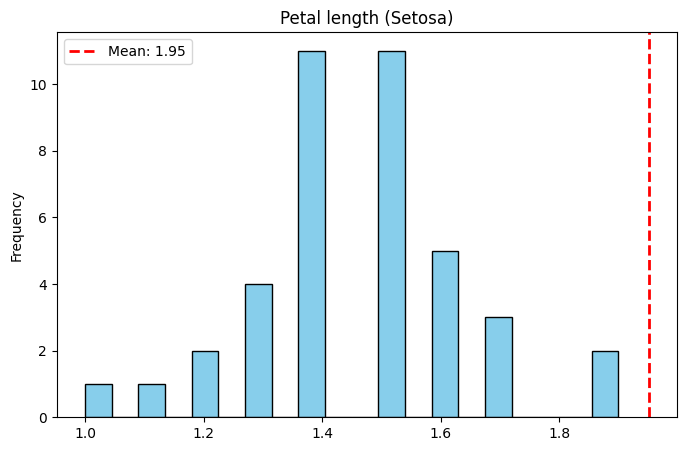

In [15]:
z_petal = zscore(data) # normalising our data
est_max = np.sqrt(2*np.log(len(data))) * data.std() + data.mean()

plt.figure(figsize=(8, 5))
plt.hist(data, bins=20, color='skyblue', edgecolor='black')
plt.axvline(est_max, color='red', linestyle='--', linewidth=2, label=f'Mean: {est_max:.2f}')
plt.ylabel('Frequency')
plt.title('Petal length (Setosa)')
plt.legend()
plt.show()

Now I say that every plant with petal length less than my estimation is classified as setosa, on the others I apply my SGD_LogRegression.

In [16]:
binary_train = df.drop(index=df.index[df['class_'] == 'Iris-setosa'])
binary_train.loc[df['class_'] == 'Iris-versicolor', df.columns == 'class_'] = 0
binary_train.loc[df['class_'] == 'Iris-virginica', df.columns == 'class_'] = 1

Y = np.array(binary_df.class_, dtype=np.float64)
X = np.array(binary_df.drop('class_', axis=1), dtype=np.float64)

# fitting my model
model = SGD_LogRegressor(max_steps=1e3, lr=0.1, batch_size=8)
model.fit(X, Y)

In [17]:
# classifying
test_copy = df_test.copy()
y_test = np.array(test_copy.class_)
test_copy = test_copy.drop('class_', axis=1)

setosa_mask = test_copy['petal_length'] <= est_max # these are setosa
test_no_setosa = test_copy[~setosa_mask].copy() # not setosa => sgd

test_setosa = test_copy[setosa_mask].copy()
test_setosa.loc[:, 'class_'] = 'Iris-setosa'

ns_pred = model.predict(np.array(test_no_setosa, dtype=np.float64))
test_no_setosa.loc[:, 'class_'] = ns_pred

# setosa + not_setosa
my_answer = pd.concat([test_setosa, test_no_setosa], axis=0, ignore_index=False)

# decoding
my_answer.loc[my_answer['class_'] == 0, 'class_'] = 'Iris-versicolor'
my_answer.loc[my_answer['class_'] == 1, 'class_'] = 'Iris-virginica'

# FINALLY
res = np.array(my_answer.sort_index().class_)
print('My accuracy: {}'.format(accuracy_score(y_test, res)))

My accuracy: 1.0


Now let's use classic Sklearn log-reg.

In [18]:
yet_an_test = df_test.copy()
y_test = np.array(yet_an_test.class_)
yet_an_test = yet_an_test.drop('class_', axis=1)

yet_an_model = LogisticRegression()
X = np.array(df_train.drop('class_', axis=1), dtype=np.float64)
X_ytest = np.array(yet_an_test, dtype=np.float64)
yet_an_model.fit(X, df_train.class_)
y_pred = yet_an_model.predict(X_ytest)
print('Sklearn accuracy: {}'.format(accuracy_score(y_test, y_pred)))

Sklearn accuracy: 1.0


# The outcome of this competition was the victory of man over machine.

Even if it isn't really fair and no cross-validation tests took place (pipeline is not easy to write).